<h1><center>US Mass Shooting Violence Analysis</center></h1>
<h2><i>Content:</i></h2>
<h2>1. Problem statement</h2>
<h2>2. Data wrangling</h2>
<h2>3. EDA</h2>
<h2>4. Modeling</h2>
<h2>5. Conclusion</h2>

<h2>1. Problem statement</h2>  
<b>Deriving a strategy to reduce the number of massive gun violent incidences across the nation</b>
<p>Gun possession & abuse is a big controversial issues within US society. Mass shooting (described as a minimum of three or four deaths due to gun violence) causing extremely serve consequencies to related people & the society. It is necessary to reveal the mechanism causing such gun crime incidences, by that deriving suggestion for the managements a foundation basis to issue & execute their gun moderator & management tools.</p>

<p>By looking at the demographics of gun accident victims for each US state. I find out the relationship between gun crime cases with key features: gun possession, unemployment rate, gender, age & education level. Now I want to use these patterns in order to derive suggestions for a policy action plan.</p>

<p>To accomplish these tasks, we will make use of data wrangling, EDA, dimensionality reduction, and unsupervised clustering.</p>
<p>The data was collected from the...</p>

<h2>2. Data wrangling</h2>

### a. Libs importing & data loading

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import datetime

from sklearn import linear_model
from sklearn import metrics
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import StandardScaler

from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression

from library.sb_utils import save_file

In [2]:
GunPossession_1986_2018 = pd.read_csv('../data/USA_Crimes/GunPossession_1986_2018.csv', index_col=0)

GunPossession_1986_2018 = GunPossession_1986_2018[['Total Licensees ','Licensed Business Entities']]
GunPossession_1986_2018.columns = ['total_licensees ','licensed_business_entities']
GunPossession_1986_2018['year'] = GunPossession_1986_2018.index

In [3]:
GunPossession_1986_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 1986 to 2018
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   total_licensees             33 non-null     object
 1   licensed_business_entities  33 non-null     object
 2   year                        33 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ KB


In [3]:
GunDeaths_2009_2018  = pd.read_csv('../data/USA_Crimes/GunDeaths_2009_2018.csv').set_index('Year')

GunDeaths_2009_2018 = GunDeaths_2009_2018[['Population','Total gun deaths','Total children and teen gun deaths']]
GunDeaths_2009_2018.columns = ['population','total_gun_deaths','total_children_teen_gun_deaths']
GunDeaths_2009_2018['year'] = GunDeaths_2009_2018.index

In [6]:
GunDeaths_2009_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 2009 to 2018
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   population                      10 non-null     object
 1   total_gun_deaths                10 non-null     object
 2   total_children_teen_gun_deaths  10 non-null     object
 3   year                            10 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 400.0+ bytes


In [4]:
Employment_header = ['FIPS Code', 'State and area', 'Year', 'Civilian non-institutional population', 
  'Civilian labor force/Total', 'Civilian labor force/Percent of population', 
  'Civilian labor force/Employment/Total', 'Civilian labor force/Employment/Percent of population',
  'Civilian labor force/Unemployment/Total','Civilian labor force/Unemployment/Rate']

Employment=pd.read_excel(
     os.path.join("../data/USA_Crimes/", "staadata.xlsx"),
     engine='openpyxl', header=None, names= Employment_header,skiprows=8
).set_index('Year')

Employment = Employment[['State and area', 'Civilian non-institutional population', 
  'Civilian labor force/Total','Civilian labor force/Unemployment/Rate']]
Employment.columns = ['state','state_population','state_labor_force','unemployment_rate']
Employment['year'] = Employment.index

In [5]:
Employment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2332 entries, 1976 to 2019
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   state              2332 non-null   object 
 1   state_population   2332 non-null   int64  
 2   state_labor_force  2332 non-null   int64  
 3   unemployment_rate  2332 non-null   float64
 4   year               2332 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 109.3+ KB


In [5]:
Mass_Shooting = pd.read_csv('../data/USA_Crimes/USMassShooting19662019(cleaned).csv', 
  parse_dates=True, index_col='Date')

MS_column_drop = ['S#','Title','Area','Incident Area','Open/Close Location','Target','Cause','Summary',
  'Shooter status','No. of shooter/suspect','Race','Latitude','Longitude']
Mass_Shooting.sort_index(inplace=True)
Mass_Shooting.drop(MS_column_drop, axis=1, inplace=True)

Mass_Shooting['date'] = pd.to_datetime(Mass_Shooting.index)
Mass_Shooting['year'] = Mass_Shooting['date'].dt.year
Mass_Shooting['month'] = Mass_Shooting['date'].dt.month
Mass_Shooting['monthday'] = Mass_Shooting['date'].dt.day
Mass_Shooting['weekday'] = Mass_Shooting['date'].dt.weekday

In [10]:
Mass_Shooting.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 339 entries, 1971-11-11 to 2066-11-12
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Location              339 non-null    object        
 1   Fatalities            339 non-null    int64         
 2   Injured               339 non-null    int64         
 3   Total victims         339 non-null    int64         
 4   Policeman Killed      339 non-null    int64         
 5   Age                   339 non-null    object        
 6   Employeed (Y/N)       339 non-null    int64         
 7   Employed at           339 non-null    object        
 8   Mental Health Issues  339 non-null    object        
 9   Gender                339 non-null    object        
 10  date                  339 non-null    datetime64[ns]
 11  year                  339 non-null    int64         
 12  month                 339 non-null    int64         
 13  m

In [6]:
#get states from locations
def get_state(txt):
    val = txt.split(", ")[-1]            
    return val

Mass_Shooting['state'] = Mass_Shooting['Location'].apply(lambda x : get_state(x))

In [7]:
name_revise = {'District of Columbia': 'Washington D.C.','NV': 'Nevada','New York city': 'New York',
'CA': 'California','Lousiana': 'Louisiana','Los Angeles County': 'California',
'Texas ': 'Texas',' Virginia': 'Virginia'}

Mass_Shooting["state"].replace(name_revise, inplace=True)
Employment["state"].replace(name_revise, inplace=True)

In [92]:
Mass_Shooting.columns

Index(['Location', 'Fatalities', 'Injured', 'Total victims',
       'Policeman Killed', 'Age', 'Employeed (Y/N)', 'Employed at',
       'Mental Health Issues', 'Gender', 'date', 'year', 'month', 'monthday',
       'weekday', 'state'],
      dtype='object')

In [8]:
Mass_Shooting.drop('Location',axis=1,inplace=True)
Mass_Shooting.columns = ['fatalities','injured','total_victims',
       'policeman_killed','age','employeed(Y/N)','employed_at',
       'mental_health_issues','gender','date','year','month','monthday','weekday','state']

Merging Data

In [9]:
print(Mass_Shooting.shape,GunPossession_1986_2018.shape,GunDeaths_2009_2018.shape,Employment.shape)

(339, 15) (33, 3) (10, 4) (2332, 5)


In [10]:
ms_df = pd.merge(Mass_Shooting,GunPossession_1986_2018,on=['year'],how='left')

In [11]:
ms_df = pd.merge(ms_df,GunDeaths_2009_2018,on=['year'],how='left')

In [12]:
ms_df = pd.merge(ms_df,Employment,on=['year','state'],how='left')

In [13]:
ms_df.set_index('date',inplace=True)

#### Filter data within 2009-2018 of which the mass shooting data is fully covered

In [14]:
df = ms_df.drop(ms_df[(ms_df.year<2009) | (ms_df.year>2018)].index)

In [14]:
df.columns

Index(['fatalities', 'injured', 'total_victims', 'policeman_killed', 'age',
       'employeed(Y/N)', 'employed_at', 'mental_health_issues', 'gender',
       'year', 'month', 'monthday', 'weekday', 'state', 'total_licensees ',
       'licensed_business_entities', 'population', 'total_gun_deaths',
       'total_children_teen_gun_deaths', 'state_population',
       'state_labor_force', 'unemployment_rate'],
      dtype='object')

In [100]:
print(Mass_Shooting.shape,GunPossession_1986_2018.shape,GunDeaths_2009_2018.shape,
  Employment.shape,df.shape)

(339, 15) (33, 3) (10, 4) (2332, 5) (244, 22)


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2009-03-10 to 2018-11-19
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   fatalities                      244 non-null    int64  
 1   injured                         244 non-null    int64  
 2   total_victims                   244 non-null    int64  
 3   policeman_killed                244 non-null    int64  
 4   age                             244 non-null    object 
 5   employeed(Y/N)                  244 non-null    int64  
 6   employed_at                     244 non-null    object 
 7   mental_health_issues            244 non-null    object 
 8   gender                          244 non-null    object 
 9   year                            244 non-null    int64  
 10  month                           244 non-null    int64  
 11  monthday                        244 non-null    int64  
 12  weekday          

<h2>3. EDA</h2>
<h3>a. Features scanning & preprocessing</h3>

#### Features engineering
Type conversion 

In [15]:
df['total_victims_log'] =  np.log10(df['total_victims'])
df['age'] = df.age.apply(lambda x: np.int(x.replace(',','')) if type(x) == str else x)
df['population'] = df.population.apply(lambda x: np.int(x.replace(',','')) if type(x) == str else x)
df['total_gun_deaths'] = df['total_gun_deaths'].apply(lambda x: np.int(x.replace(',','')) if type(x) == str else x)
df['total_children_teen_gun_deaths'] = df['total_children_teen_gun_deaths'].apply(lambda x: np.int(x.replace(',','')) if type(x) == str else x)
df['licensed_business_entities'] = df['licensed_business_entities'].apply(lambda x: np.int(x.replace(',','')) if type(x) == str else x)

Feature extraction

In [16]:
sectors = {'retail': ['Weis grocery','Advance Granite Store'], 'it': ['Yahoo','Virginia TV'],
  'military': ['Fort Hood','Army veteran','former Marine','U.S Army','Military','Navy Yard','former military'],
  'manufacturing': ['manufacturing company','manufacturer Fiamma Inc.','factory'],
  'education': ['University of Alabama'], 'other': '-999',
  'hospitality': ['county health department','some nursing home'],
  'transportation': ['uber','FedEx']}
  
def get_sector(comp):
  for key, val in sectors.items():
    if comp in val:
      comp = key            
  return comp

df['sectors'] = df['employed_at'].apply(lambda x: get_sector(x))    

In [17]:
null_val = {-999.000000: 0}
df['age'].replace(null_val, inplace=True)

In [18]:
age_groups = {'child':[5,16],'young_adult':[16,30],'middle_age_adult':[30,45],
  'old_adult':[45,125],'other':[0,5]}

def age_group(age):
  for key, val in age_groups.items():
    if age in range(val[0],val[-1]):
      age = key            
  return age

df['age_group'] = df['age'].apply(lambda x: age_group(x))  

Encoding category variables

In [19]:
gender_code = {'-999': 0,'Male': 1,'Female': 2,'Male and Female':3}
health_code = {'-999': 0,'Yes': 1,'No': 2}
sector_code = {'other':0,'it':1,'military':2,'hospitality':3,'retail':4,'manufacturing':5,
  'education':6,'transportation':7}
age_code = {'other':0,'child':1,'young_adult':2,'middle_age_adult':3,'old_adult':4}

df['policeman_killed'].replace(null_val, inplace=True)
df['age'].replace(null_val, inplace=True)
df['employeed(Y/N)'].replace(null_val, inplace=True)
df.gender.replace(gender_code,inplace=True)
df['mental_health_issues'].replace(health_code,inplace=True)
df.sectors.replace(sector_code,inplace=True)
df.age_group.replace(age_code,inplace=True)

In [20]:
df = df.drop(['fatalities', 'injured','policeman_killed',
  'employed_at','population','state_labor_force','total_licensees ',
  'total_children_teen_gun_deaths'], axis=1)
df['date'] = pd.to_datetime(df.index)
df['date'] = df['date'].map(datetime.datetime.toordinal)

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2009-03-10 to 2018-11-19
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   total_victims               244 non-null    int64  
 1   age                         244 non-null    int64  
 2   employeed(Y/N)              244 non-null    int64  
 3   mental_health_issues        244 non-null    int64  
 4   gender                      244 non-null    int64  
 5   year                        244 non-null    int64  
 6   month                       244 non-null    int64  
 7   monthday                    244 non-null    int64  
 8   weekday                     244 non-null    int64  
 9   state                       244 non-null    object 
 10  licensed_business_entities  244 non-null    int64  
 11  total_gun_deaths            244 non-null    int64  
 12  state_population            244 non-null    float64
 13  unemployment_rat

#### b. Data quality assessment 

In [21]:
df[['total_victims','age','employeed(Y/N)','mental_health_issues','gender','licensed_business_entities',
  'total_gun_deaths','state_population','unemployment_rate','sectors']].describe()

,total_victims,age,employeed(Y/N),mental_health_issues,gender,licensed_business_entities,total_gun_deaths,state_population,unemployment_rate,sectors
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,2.440000e+02,244.000000,244.000000
mean,10.176230,14.532787,0.090164,0.704918,0.946721,77285.282787,36521.954918,1.012367e+07,5.993852,0.299180
std,38.332712,18.843599,0.287005,0.813351,0.427007,5080.585517,2472.757342,8.174163e+06,1.894937,1.083281
min,3.000000,0.000000,0.000000,0.000000,0.000000,60349.000000,31347.000000,5.380540e+05,2.800000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,1.000000,77815.000000,33636.000000,4.727283e+06,4.700000,0.000000
50%,5.000000,0.000000,0.000000,0.000000,1.000000,79188.000000,36252.000000,7.758751e+06,5.500000,0.000000
75%,8.000000,29.000000,0.000000,1.000000,1.000000,80119.000000,38658.000000,1.564546e+07,6.600000,0.000000
max,585.000000,70.000000,1.000000,2.000000,3.000000,80493.000000,39773.000000,3.098267e+07,13.000000,7.000000


In [21]:
df.columns

Index(['total_victims', 'age', 'employeed(Y/N)', 'mental_health_issues',
       'gender', 'year', 'month', 'monthday', 'weekday', 'state',
       'licensed_business_entities', 'total_gun_deaths', 'state_population',
       'unemployment_rate', 'total_victims_log', 'sectors', 'age_group',
       'date'],
      dtype='object')

#### c. Analyzing & Visualization  
- Tagert (y): total_victims  
- Features (Xi): population, state_population, age, gender, total_licensees, unemployment_rate, employees, mental_health_issues

In [22]:
df_visual = df.drop(columns=['year','month','monthday','weekday','total_victims_log',
  'state','date','age_group'])

df_visual.columns

Index(['total_victims', 'age', 'employeed(Y/N)', 'mental_health_issues',
       'gender', 'licensed_business_entities', 'total_gun_deaths',
       'state_population', 'unemployment_rate', 'sectors'],
      dtype='object')

C:\Users\Binhkn\anaconda3\envs\DS\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


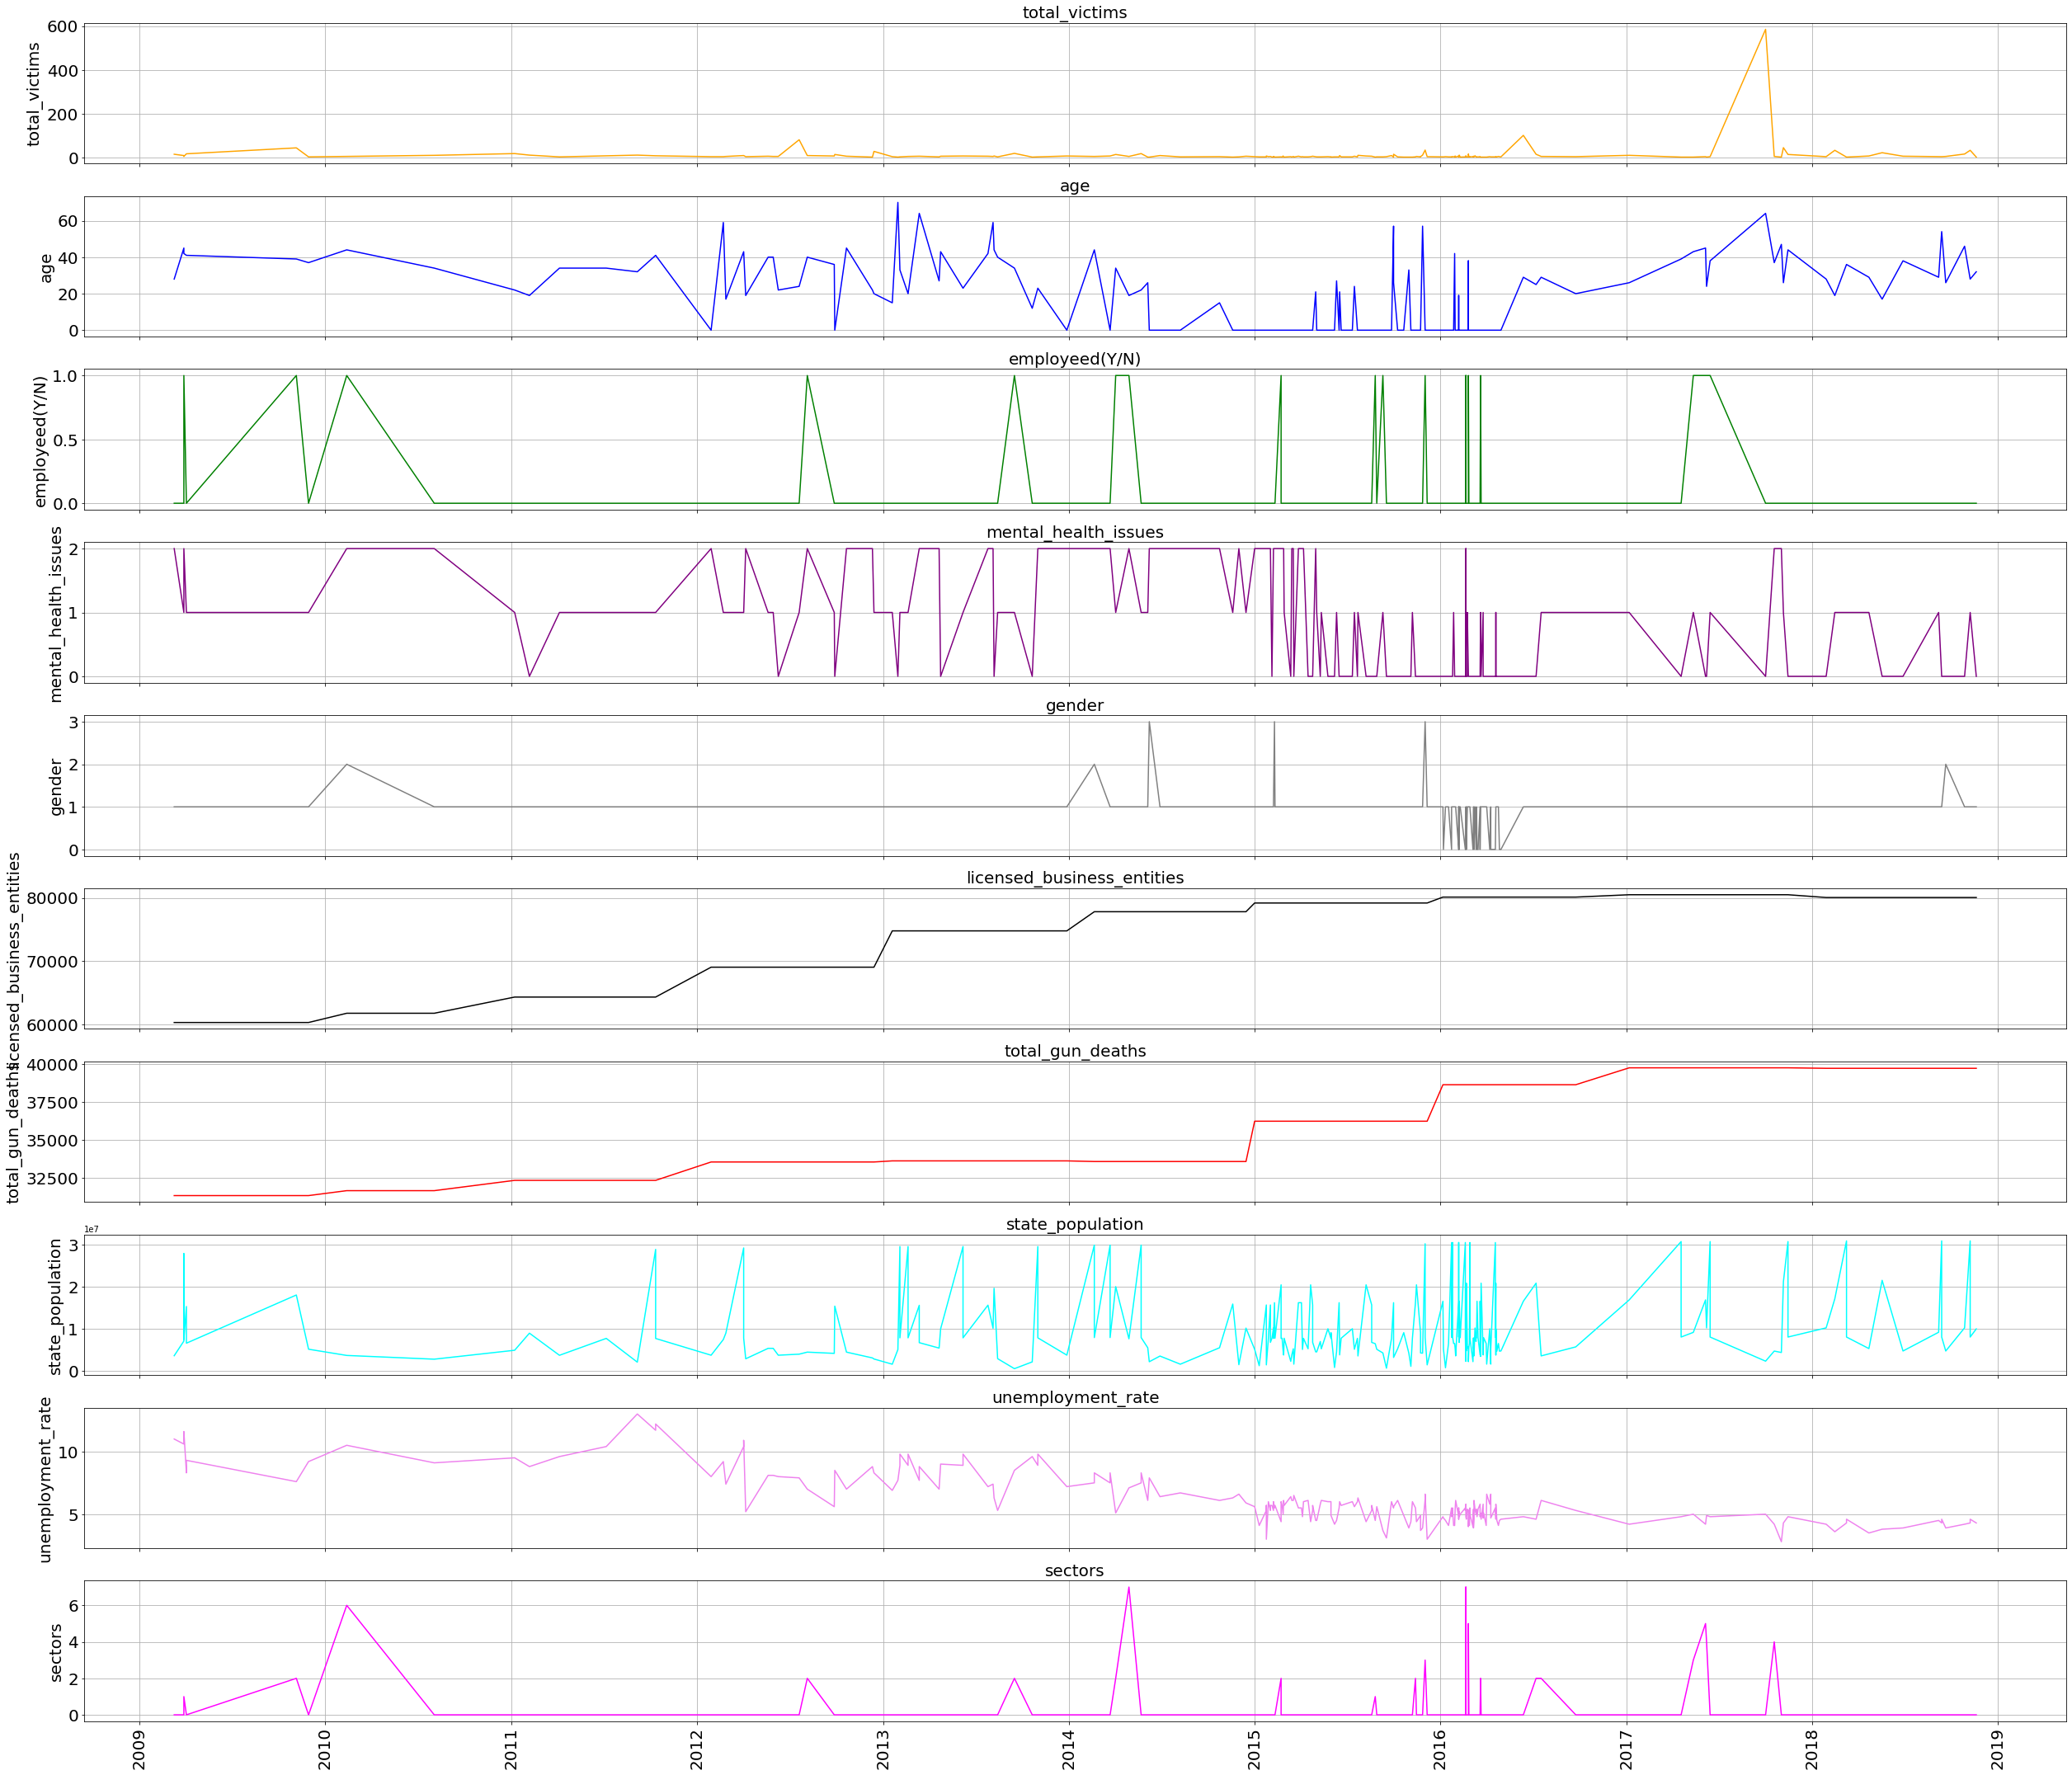

In [32]:
fig, ax = plt.subplots(nrows=len(df_visual.columns), ncols=1, sharex=True, figsize=(35,30))
colors = ['orange', 'blue', 'green', 'purple', 'gray', 'black', 'red','cyan','violet','magenta']

for i, val in enumerate(df_visual.columns):  
  ax[i].plot(df_visual.index, df_visual[val], color=colors[i])   
  ax[i].set_title(val, fontsize=20)
  ax[i].grid(True)
  ax[i].set_ylabel(val, fontsize=20)
  ax[i].tick_params(axis="y", labelsize=20)

# N = 3  # 1 tick every 3
# xticks_pos = ax[0].get_xticks()
# xticks_labels = ax[0].get_xticklabels()
# myticks = [j for i,j in enumerate(xticks_pos) if not i%N]  # index of selected ticks
# newlabels = [label for i,label in enumerate(xticks_labels) if not i%N]
# plt.gca().set_xticks(myticks)
plt.xticks(fontsize=20, rotation=90)


plt.tight_layout(1.1)
plt.show()

In [113]:
def plot_gb_time_series(df, ts_name, gb_name, value_name, figsize=(20,7), title=None):
    fig, ax = plt.subplots(figsize=figsize)
    for key, grp in df.groupby([gb_name]):
        ax = grp.plot(ax=ax, kind='line', x=ts_name, y=value_name, label=key, marker='o')
    ax.autoscale_view()
    ax.legend(loc='upper left')
    _ = plt.xticks(rotation=90, )
    _ = plt.grid()
    _ = plt.xlabel('')
    _ = plt.ylim(0, df[value_name].max() * 1.25)
    _ = plt.ylabel(value_name)
    if title is not None:
        _ = plt.title(title)
    _ = plt.show()

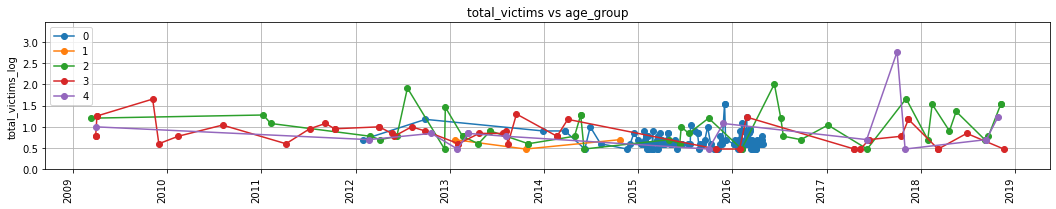

In [114]:
plot_gb_time_series(df, 'date', 'age_group', 'total_victims_log',
                    figsize=(18, 3), title='total_victims vs age_group')

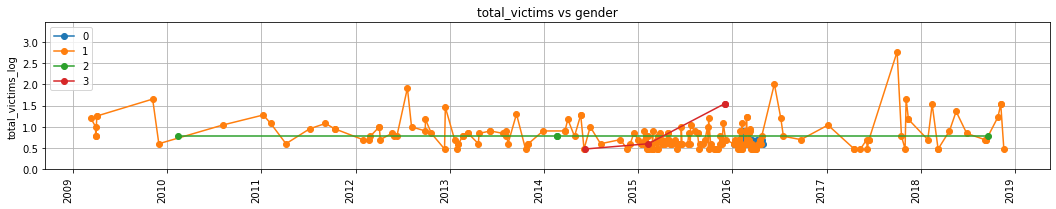

In [115]:
plot_gb_time_series(df, 'date', 'gender', 'total_victims_log',
                    figsize=(18, 3), title='total_victims vs gender')

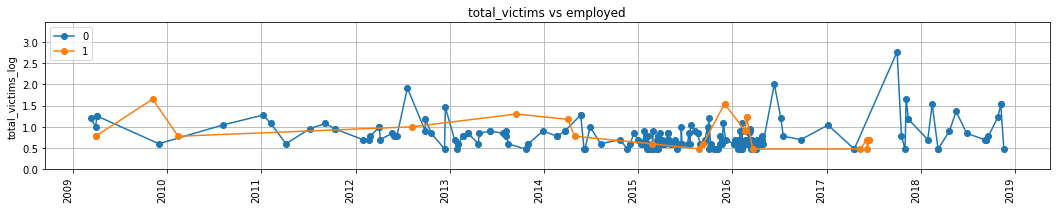

In [116]:
plot_gb_time_series(df, 'date', 'employeed(Y/N)', 'total_victims_log',
                    figsize=(18, 3), title='total_victims vs employed')

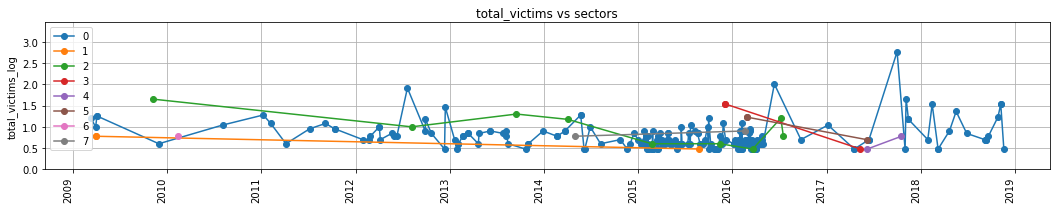

In [117]:
plot_gb_time_series(df, 'date', 'sectors', 'total_victims_log',
                    figsize=(18, 3), title='total_victims vs sectors')

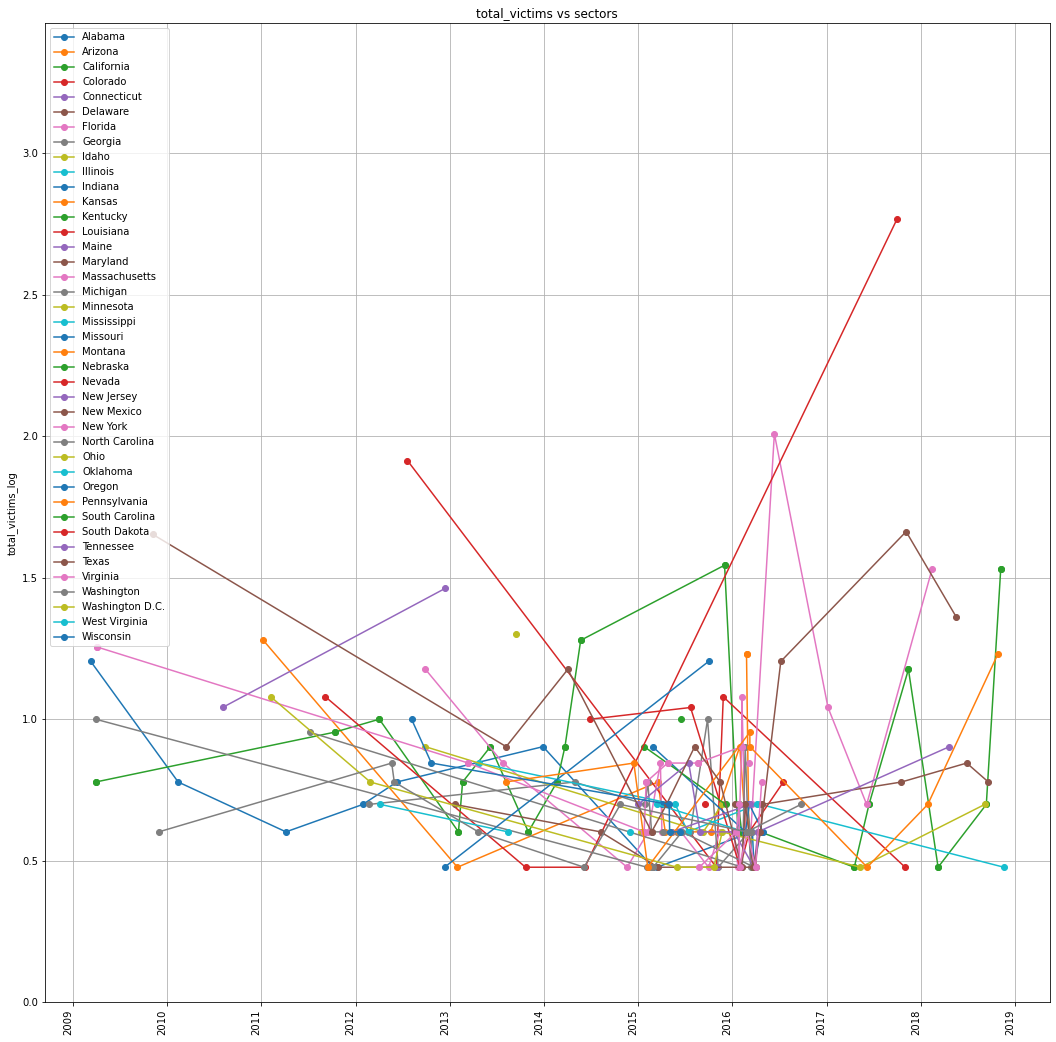

In [118]:
plot_gb_time_series(df, 'date', 'state', 'total_victims_log',
                    figsize=(18, 20), title='total_victims vs sectors')

C:\Users\Binhkn\anaconda3\envs\DS\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


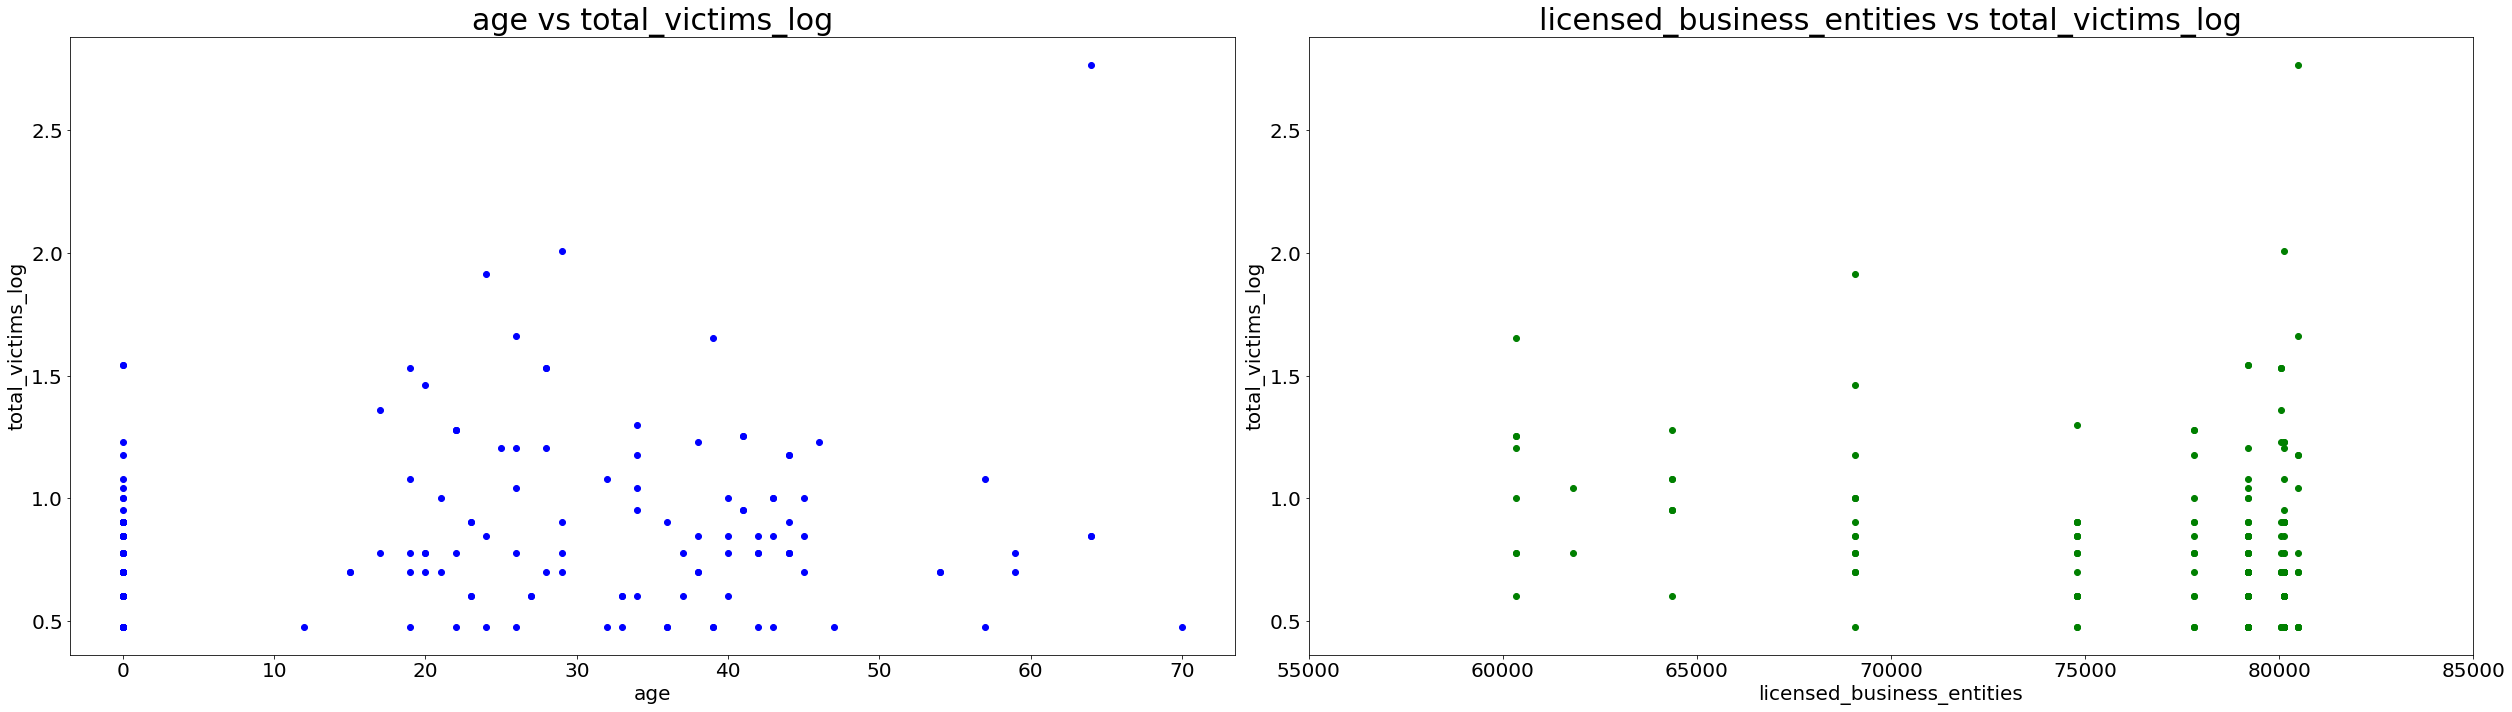

In [45]:
fig, ax = plt.subplots(1, 2, sharey=False, figsize=(35,10))
colors = ['blue', 'green']
cols = ['age','licensed_business_entities','total_victims_log']

for m in range(len(colors)):
  ax[m].scatter(df[cols[m]], df[cols[-1]], color=colors[m])  
  ax[m].set_title('{} vs {}'.format(cols[m],cols[-1]), fontsize=30)
  ax[m].set_xlabel(cols[m],fontsize=20)
  ax[m].set_ylabel(cols[-1],fontsize=20)
  plt.sca(ax[m])
  ax[m].xaxis.set_tick_params(labelsize=20)
  ax[m].yaxis.set_tick_params(labelsize=20)

ax[1].set_xlim(55000,85000)

plt.tight_layout(1.1)
plt.show()

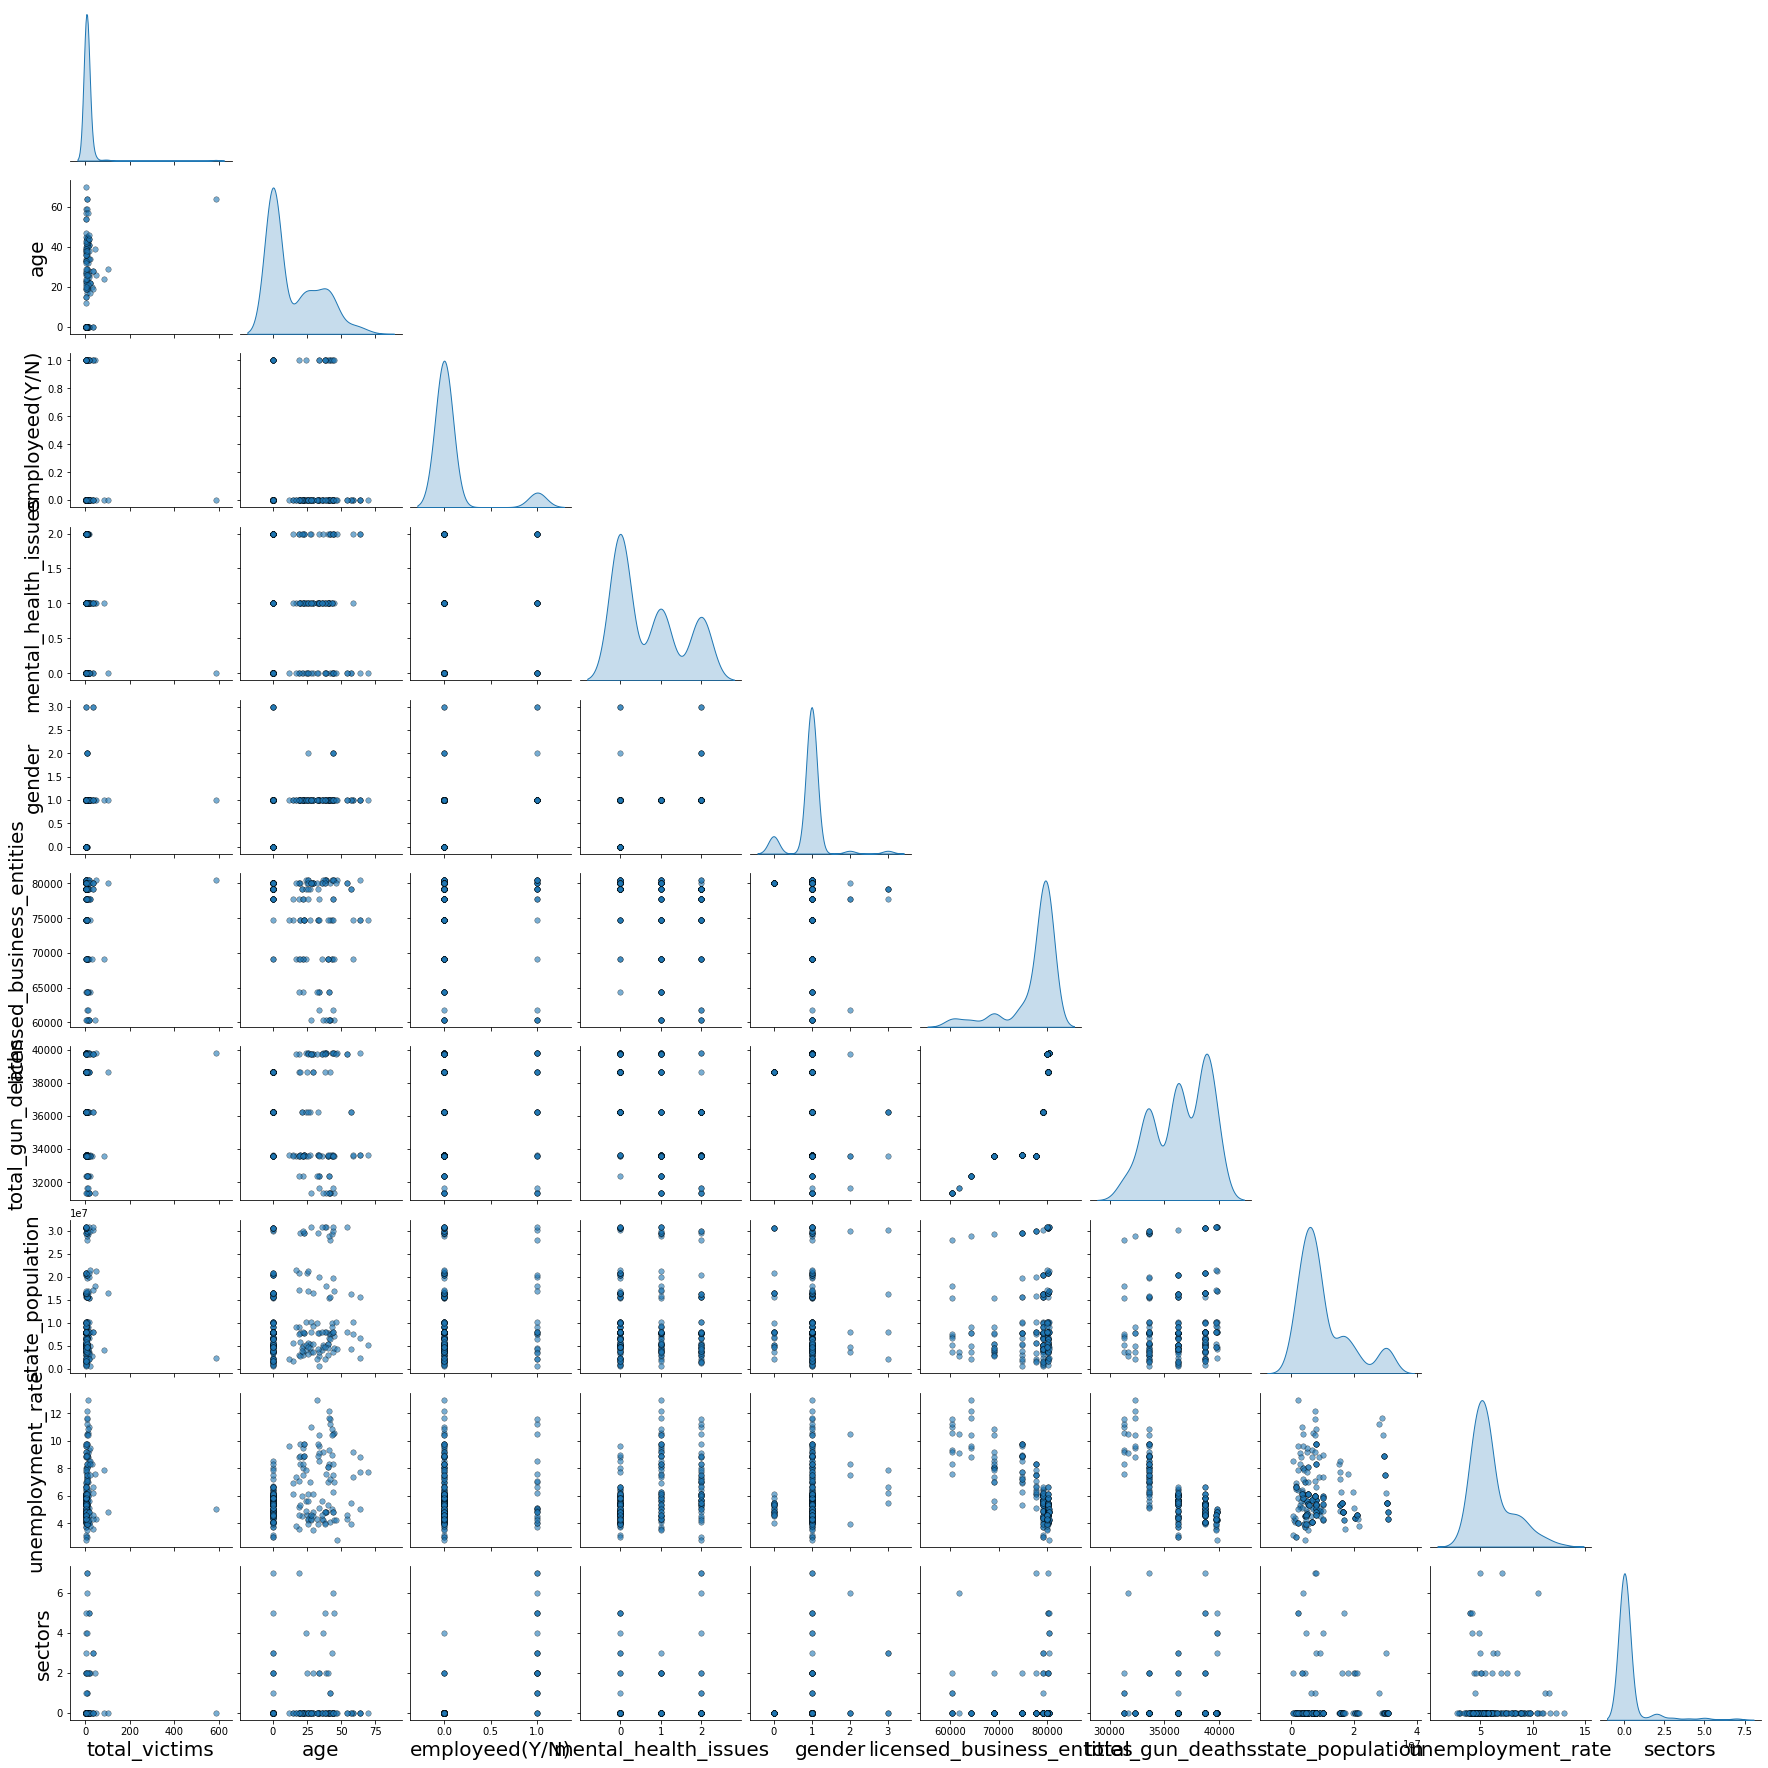

In [47]:
sns.pairplot(df_visual, vars=df_visual.columns, diag_kind='kde', corner=True,
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

<Figure size 576x360 with 0 Axes>

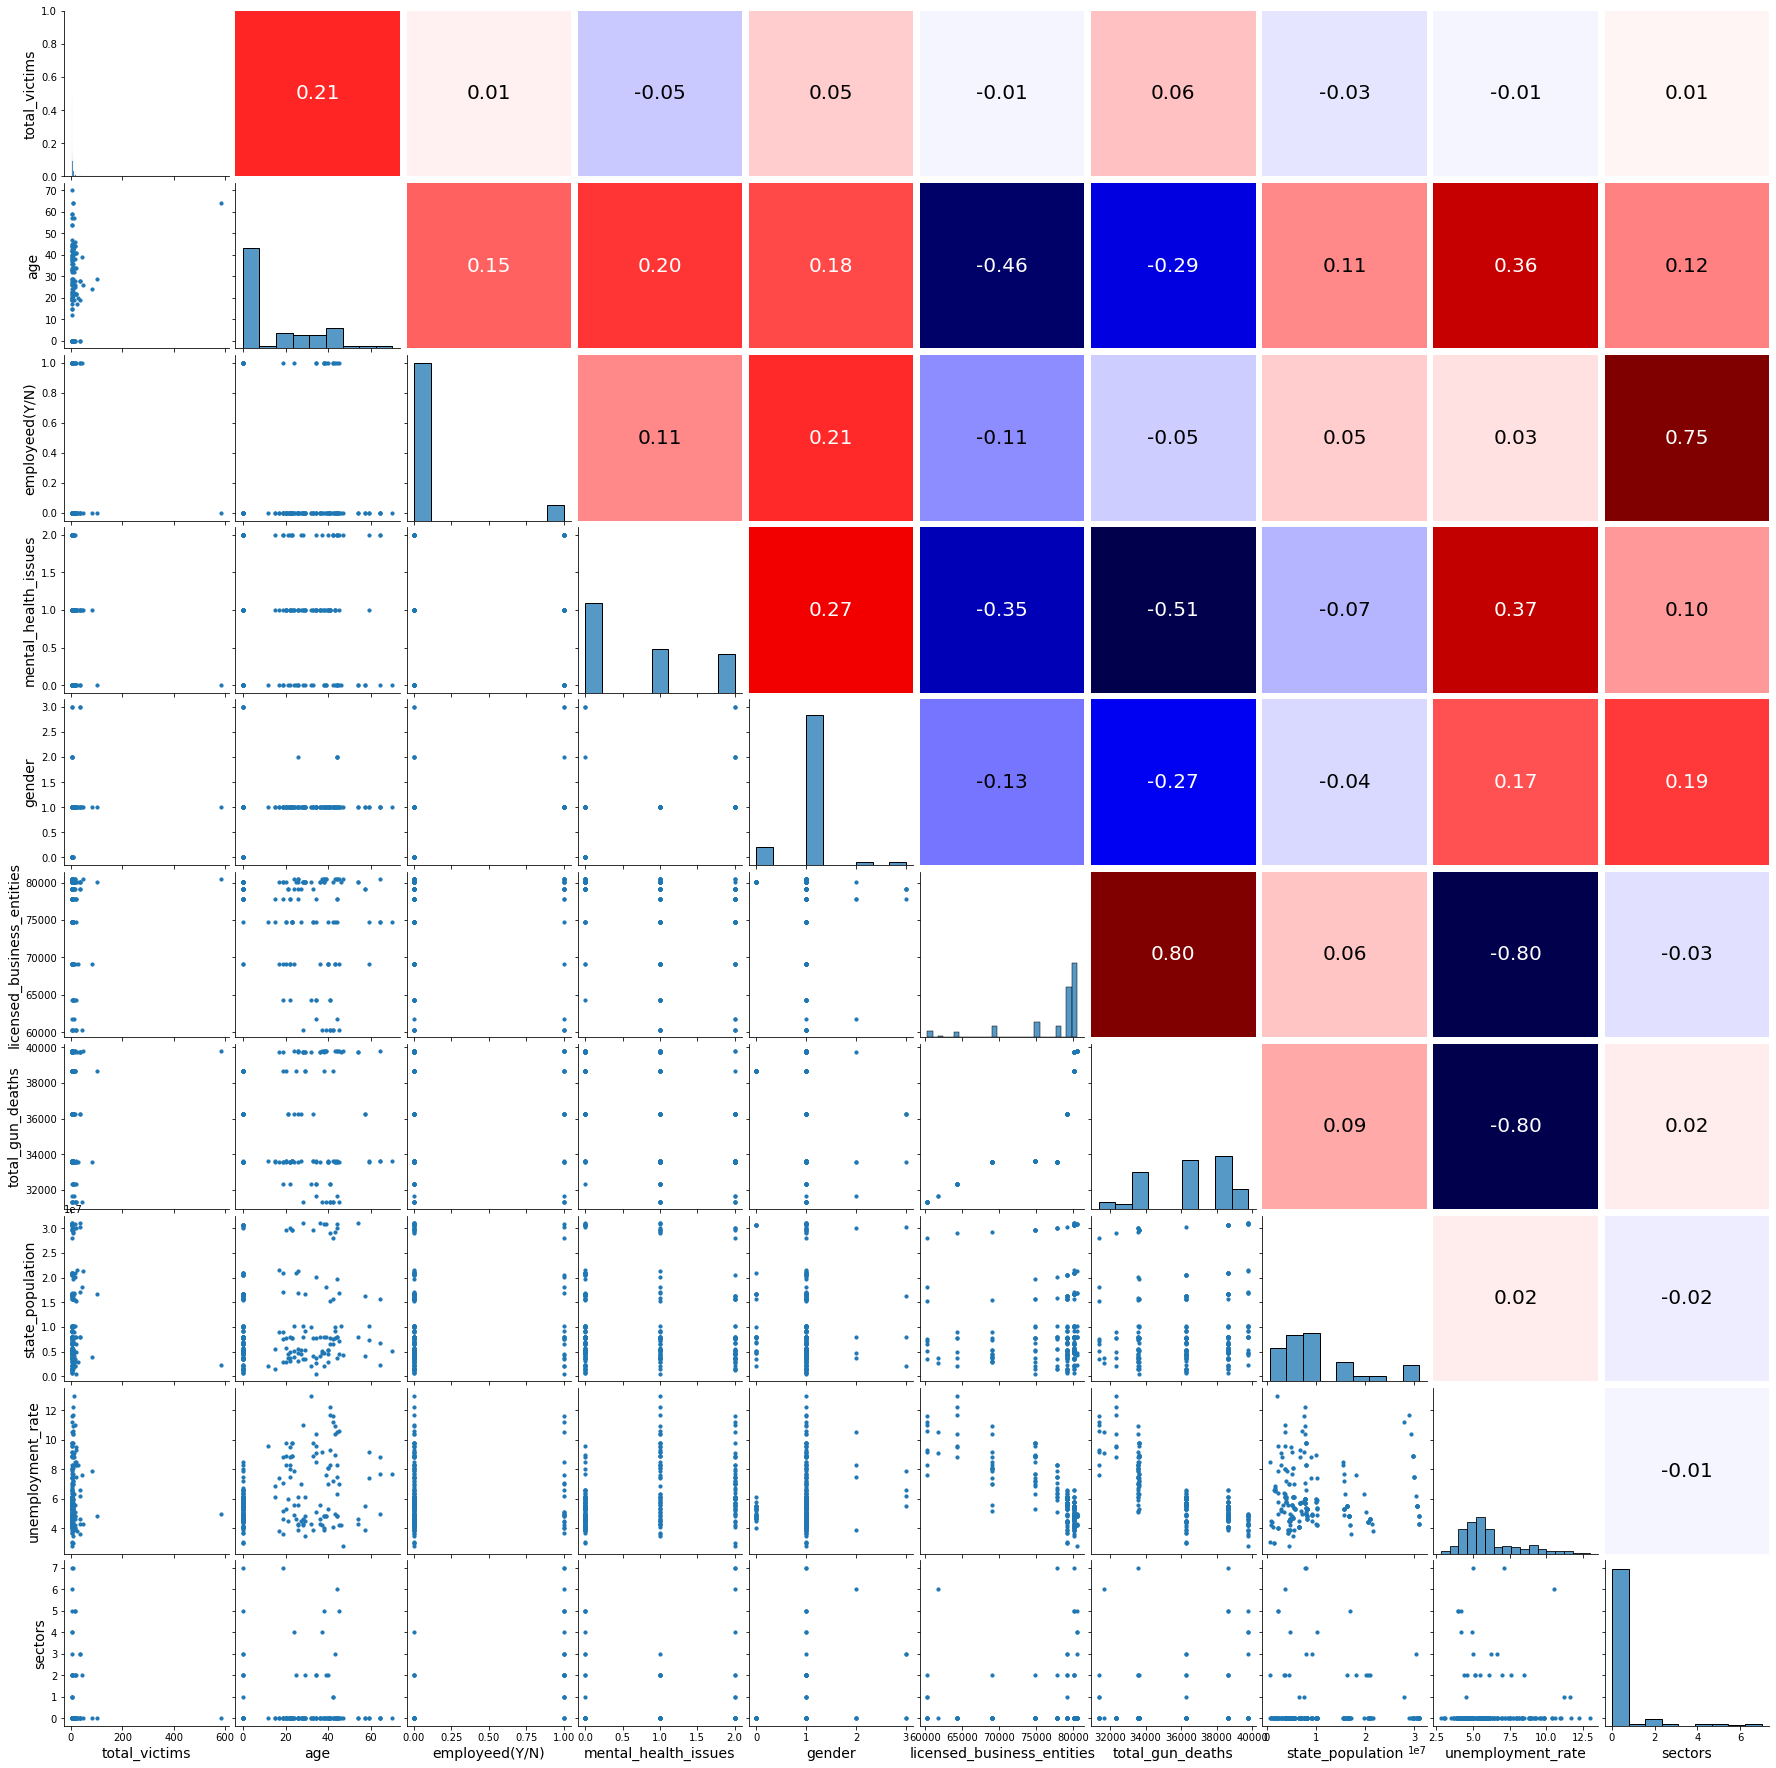

In [50]:
from scipy.stats import pearsonr

def corrfunc(x, y, **kwds):
    cmap = kwds['cmap']
    norm = kwds['norm']
    ax = plt.gca()
    ax.tick_params(bottom=False, top=False, left=False, right=False)
    sns.despine(ax=ax, bottom=True, top=True, left=True, right=True)
    r, _ = pearsonr(x, y)
    facecolor = cmap(norm(r))
    ax.set_facecolor(facecolor)
    lightness = (max(facecolor[:3]) + min(facecolor[:3]) ) / 2
    ax.annotate(f"{r:.2f}", xy=(.5, .5), xycoords=ax.transAxes,
                color='white' if lightness < 0.7 else 'black', size=20, ha='center', va='center')


plt.figure(figsize=(8,5))
g = sns.PairGrid(df_visual)
plt.rcParams["axes.labelsize"] = 12
g.map_lower(plt.scatter, s=10)
g.map_diag(sns.histplot, kde=False)
g.map_upper(corrfunc, cmap=plt.get_cmap('seismic'), norm=plt.Normalize(vmin=-.5, vmax=.5))
g.fig.subplots_adjust(wspace=0.04, hspace=0.04) # equal spacing in both directions
plt.show()

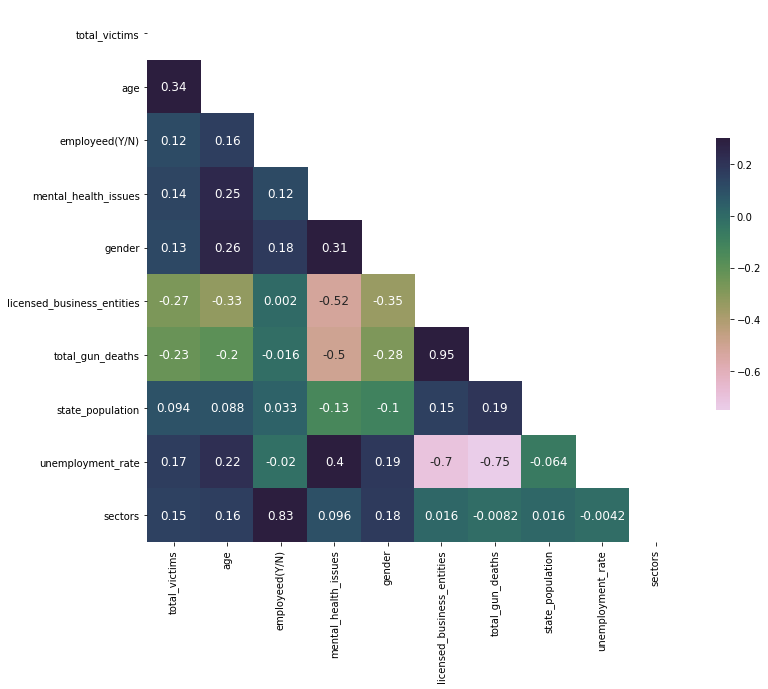

In [49]:
fig, ax = plt.subplots(figsize=(12, 10))

# Generate a mask for the upper triangle
corr = df_visual.corr(method = 'spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(n_colors=12, start=-2.25, rot=-1.3, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# cbar_kws: for positioning cbar and "shrink" for reducing cbar size
sns.heatmap(corr , annot=True, annot_kws={'size': 12}, mask=mask, cmap=cmap, vmax=.3, square=True, cbar_kws={"shrink": .5}, ax=ax)

plt.show()

As the heat map above, the **age, licensed_business_entities & unemployment_rate** features are weakly associated with the **total_victims**. Meanwhile there are also associations between licensed_business_entities and the other features (**total_gun_deaths, mental_health_issues**), so it might be worth trying to predict **total_victims** in a way that accounts for all 10 features?.

<h2>4. Modeling</h2>

In [23]:
#One-hot encoding for State feature
df_dm = pd.get_dummies(df,columns=['state'],prefix='state')
df_dm.drop('total_victims_log',axis=1,inplace=True)

In [24]:
cols = df_dm.columns.map(lambda x: x.replace(' ','_'))
cols = cols.map(lambda x: x.replace('.',''))
cols = cols.map(lambda x: x.replace('(Y/N)',''))

In [25]:
df_dm.columns = cols

In [102]:
df_dm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2009-03-10 to 2018-11-19
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   total_victims               244 non-null    int64  
 1   age                         244 non-null    int64  
 2   employeed                   244 non-null    int64  
 3   mental_health_issues        244 non-null    int64  
 4   gender                      244 non-null    int64  
 5   year                        244 non-null    int64  
 6   month                       244 non-null    int64  
 7   monthday                    244 non-null    int64  
 8   weekday                     244 non-null    int64  
 9   licensed_business_entities  244 non-null    int64  
 10  total_gun_deaths            244 non-null    int64  
 11  state_population            244 non-null    float64
 12  unemployment_rate           244 non-null    float64
 13  sectors         

In [26]:
#Data with dummy 'state' features
X_train, X_test, y_train, y_test = train_test_split(df_dm.drop(columns='total_victims'), 
                                                    df_dm['total_victims'], test_size=0.3, 
                                                    random_state=47)

In [201]:
print(X_train.shape, X_test.shape,y_train.shape, y_test.shape)

(170, 56) (74, 56) (170,) (74,)


In [34]:
#Data with 16 features
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['total_victims','state','total_victims_log']), 
                                                    df['total_victims'], test_size=0.3, 
                                                    random_state=47)

In [35]:
print(X_train.shape, X_test.shape,y_train.shape, y_test.shape)

(170, 15) (74, 15) (170,) (74,)


#### Linear Regression

In [27]:
lr_pipe = make_pipeline(
    StandardScaler(), 
    SelectKBest(score_func=f_regression),
    LinearRegression()
)

In [28]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000017D88AC0708>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [ ]:
lr_grid_cv.cv_results_

In [ ]:
#list all methods in a python class
# dir(lr_grid_cv)

#print the usage of a python class
print(help(lr_grid_cv))

In [29]:
lr_score_mean = lr_grid_cv.cv_results_['mean_test_score']
lr_score_std = lr_grid_cv.cv_results_['std_test_score']
lr_cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]
lr_grid_cv.best_params_

{'selectkbest__k': 2}

Text(0.5, 1.0, 'Pipeline mean CV score (error bars +/- 1sd)')

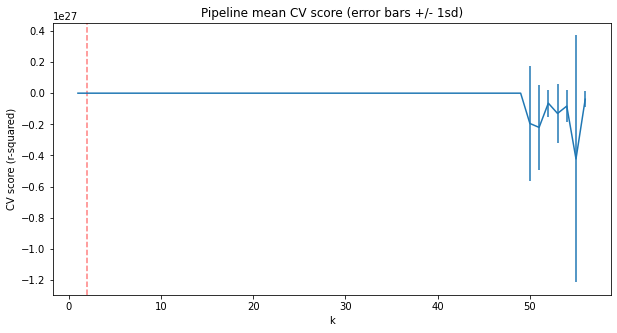

In [30]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(lr_cv_k, lr_score_mean, yerr=lr_score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')

In [31]:
lr_selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[lr_selected]
pd.Series(coefs, index=features).sort_index(ascending=True)

age              6.198621
state_Nevada    30.105497
dtype: float64

In [32]:
y_lr_pred = lr_grid_cv.best_estimator_.predict(X_test)

Linear regression model performance

In [33]:
print(r2_score(y_test, y_lr_pred),mean_absolute_error(y_test, y_lr_pred),
  mean_squared_error(y_test, y_lr_pred))

-9.377774682276671 14.75363028308686 2342.018893983974


In [34]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [35]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(11.97414040601239, 6.9656118531437565)

#### Linear Regression vs Lasso & Ridge

In [36]:
def test(models, iterations = 100):
    results = {}
    for i in models:
        r2_train = [] 
        r2_test = []
        rmse_train = []
        rmse_test = []
        for j in range(iterations):
            r2_test.append(metrics.r2_score(y_test, models[i].fit(X_train,y_train).predict(X_test)))
            r2_train.append(metrics.r2_score(y_train, models[i].fit(X_train,y_train).predict(X_train)))
            rmse_test.append(metrics.mean_squared_error(y_test, models[i].fit(X_train,y_train).predict(X_test),squared=False))
            rmse_train.append(metrics.mean_squared_error(y_train, models[i].fit(X_train,y_train).predict(X_train),squared=False))
        results[i] = [np.mean(r2_train), np.mean(r2_test), np.mean(rmse_train), np.mean(rmse_test)]
    return pd.DataFrame(results)


In [37]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

models = {'LR': LinearRegression(),
           'Lasso': GridSearchCV(linear_model.Lasso(), param_grid=lasso_params).fit(X_train,y_train).best_estimator_,
           'Ridge': GridSearchCV(linear_model.Ridge(), param_grid=ridge_params).fit(X_train,y_train).best_estimator_,}


test(models)


,LR,Lasso,Ridge
0,0.599766,0.596254,0.136911
1,-8.959155,-8.605661,-0.339852
2,28.307672,28.431599,41.569494
3,47.408293,46.559329,17.388874


#### Ordinary Least Square Model

In [38]:
def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)
formula = get_formula(df_dm.columns.to_list()[1:],'total_victims')
formula

'total_victims ~ 0 + age + employeed + mental_health_issues + gender + year + month + monthday + weekday + licensed_business_entities + total_gun_deaths + state_population + unemployment_rate + sectors + age_group + date + state_Alabama + state_Arizona + state_California + state_Colorado + state_Connecticut + state_Delaware + state_Florida + state_Georgia + state_Idaho + state_Illinois + state_Indiana + state_Kansas + state_Kentucky + state_Louisiana + state_Maine + state_Maryland + state_Massachusetts + state_Michigan + state_Minnesota + state_Mississippi + state_Missouri + state_Montana + state_Nebraska + state_Nevada + state_New_Jersey + state_New_Mexico + state_New_York + state_North_Carolina + state_Ohio + state_Oklahoma + state_Oregon + state_Pennsylvania + state_South_Carolina + state_South_Dakota + state_Tennessee + state_Texas + state_Virginia + state_Washington + state_Washington_DC + state_West_Virginia + state_Wisconsin'

In [39]:
model_ols = ols(formula=formula,data=df_dm).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          total_victims   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     2.055
Date:                Mon, 01 Nov 2021   Prob (F-statistic):           0.000189
Time:                        23:39:51   Log-Likelihood:                -1178.0
No. Observations:                 244   AIC:                             2468.
Df Residuals:                     188   BIC:                             2664.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
age                            2.5690      0.780      3.295      0.001       1.031       4.107
employeed                     -6.8020     13.640     -0.499      0.619     -33.709      20.105
mental_health_issues          -0.0353      3.876     -0.009      0.993      -7.682       7.611
gender                        -1.4717      6.225     -0.236      0.813     -13.752      10.809
year                          79.5665   1252.106      0.064      0.949   -2390.417    2549.550
month                          8.2679    104.273      0.079      0.937    -197.428     213.964
monthday                      -0.1906      3.430     -0.056      0.956      -6.958       6.577
weekday                        3.1950      1.283      2.489      0.014       0.663       5.727
licensed_business_entities    -0.0005      0.002     -0.250      0.803      -0.004       0.003
total_gun_deaths               0.0040      0.004      0.920      0.359      -0.005       0.013
state_population            -1.93e-07   4.52e-07     -0.427      0.670   -1.08e-06    6.99e-07
unemployment_rate            -10.6383      4.287     -2.482      0.014     -19.095      -2.182
sectors                        1.8368      3.528      0.521      0.603      -5.122       8.796
age_group                    -28.2958     11.151     -2.538      0.012     -50.293      -6.299
date                          -0.2426      3.430     -0.071      0.944      -7.010       6.524
state_Alabama                1.81e+04   1.66e+04      1.094      0.276   -1.46e+04    5.08e+04
state_Arizona                1.81e+04   1.66e+04      1.094      0.276   -1.46e+04    5.08e+04
state_California            1.811e+04   1.66e+04      1.094      0.275   -1.45e+04    5.08e+04
state_Colorado              1.809e+04   1.65e+04      1.093      0.276   -1.46e+04    5.07e+04
state_Connecticut           1.811e+04   1.66e+04      1.095      0.275   -1.45e+04    5.08e+04
state_Delaware               1.81e+04   1.66e+04      1.093      0.276   -1.46e+04    5.07e+04
state_Florida                1.81e+04   1.66e+04      1.093      0.276   -1.46e+04    5.07e+04
state_Georgia                1.81e+04   1.66e+04      1.094      0.276   -1.46e+04    5.08e+04
state_Idaho                 1.808e+04   1.66e+04      1.092      0.276   -1.46e+04    5.07e+04
state_Illinois              1.811e+04   1.66e+04      1.094      0.275   -1.45e+04    5.08e+04
state_Indiana               1.808e+04   1.66e+04      1.092      0.276   -1.46e+04    5.07e+04
state_Kansas                1.808e+04   1.66e+04      1.093      0.276   -1.46e+04    5.07e+04
state_Kentucky              1.809e+04   1.66e+04      1.093      0.276   -1.46e+04    5.07e+04
state_Louisiana              1.81e+04   1.66e+04      1.094      0.276   -1.46e+04    5.08e+04
state_Maine                 1.808e+04   1.6

In [49]:
y_ols_pred = model_ols.predict(X_test)

In [50]:
print(r2_score(y_test, y_ols_pred),mean_absolute_error(y_test, y_ols_pred),
  mean_squared_error(y_test, y_ols_pred))

-2.0108298399410387 14.786240436554795 679.4732577645173


Random Forest Model

In [40]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [41]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None]
}
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [42]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 42, 'standardscaler': StandardScaler()}

In [43]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([-1.25536863e-02, -6.59801324e-02,  1.55399535e-01, -1.04126776e+01,
       -7.32210312e+01])

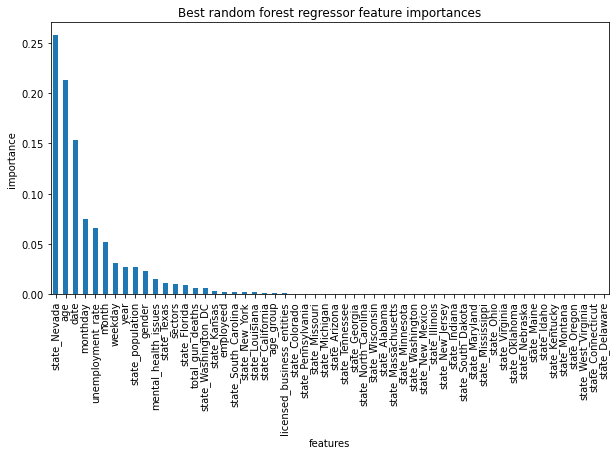

In [44]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [45]:
y_rf_pred = rf_grid_cv.best_estimator_.predict(X_test)

Random Forest regression model performance

In [46]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [47]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(10.416491596638654, 6.140295003698771)

In [48]:
print(r2_score(y_test, y_rf_pred),mean_absolute_error(y_test, y_rf_pred),
  mean_squared_error(y_test, y_rf_pred))

-2.7007983053259483 10.040567353067352 835.182861379662


Save best model object from pipeline

In [120]:
best_model = rf_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [ ]:
modelpath = '../models'
save_file(best_model, 'mass_shooting_RF_Model.pkl', modelpath)

<h2>5. Conclusion</h2>

4 types of linear regression models have been conducted with all negative R2. Ridge seems working the best among them with less negative R2, lowest RMSE in both train & test sets.  
Inspite of negative R2 value, Random forest shows more promissing result because of lowest MAE & MSE values. 5 most important features are captures: state_Nevada, age, date, monthday, unemployment_rate.

Need a discussion about the performance of both Linear & RF regression:  
- Keys important features of both regressions are state_Nevada & age  
- Negative R-square  
- High MAE & MSE